In [11]:
import sys
!{sys.executable} -m pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 7.1 MB/s eta 0:00:00m eta 0:00:010:00:01


In [12]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [13]:
# configuring figure/plot params
custom_params = {'figure.figsize':(17,9)} 
sns.set_theme(style="whitegrid", rc=custom_params)

In [3]:
mnist_data = pd.read_csv('mnist.csv').values
df_describe = pd.DataFrame(mnist_data)
df_describe.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


# Data Exploration
Exploring data and plotting cool stuff

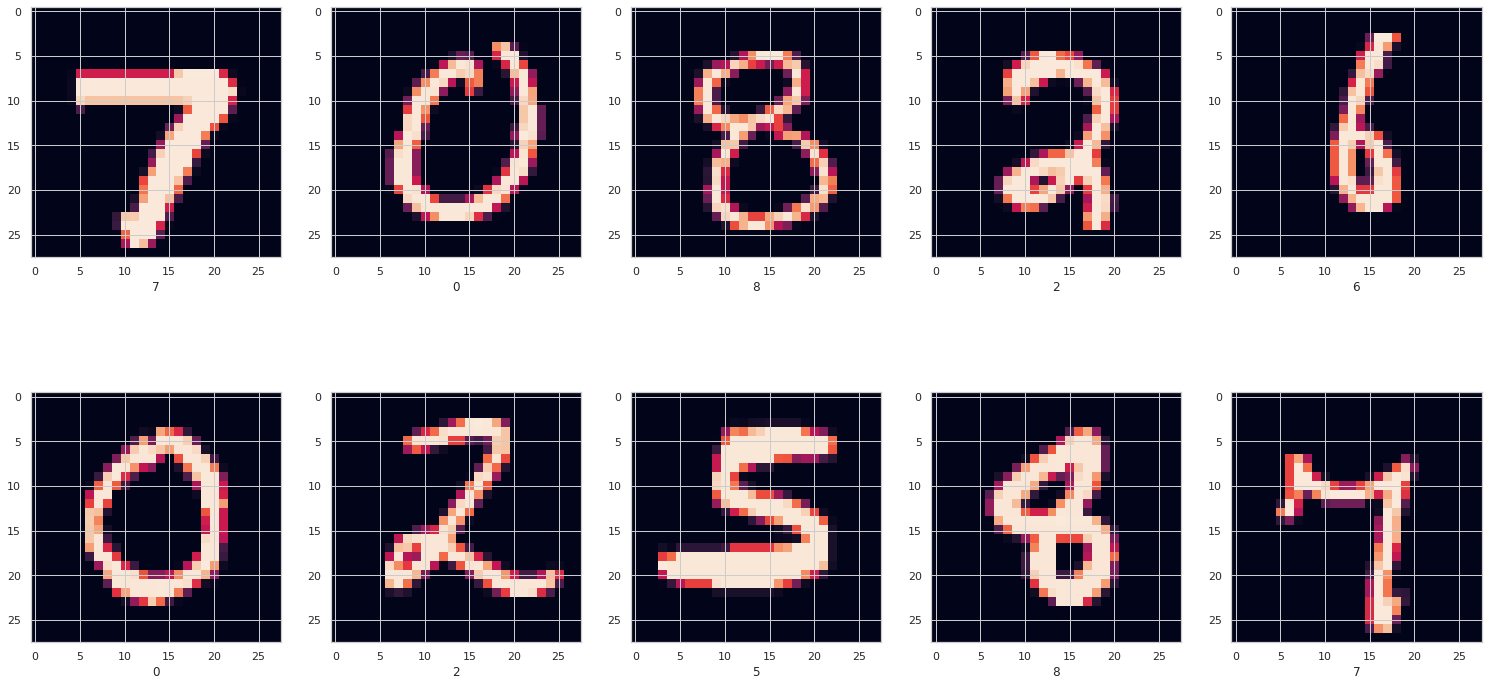

In [4]:
labels = mnist_data[:,0] # 0 to 9
digits = mnist_data[:, 1:] # 42000 digits
img_size = 28

fig = plt.figure(figsize=(26,13))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digits))
    plt.imshow(digits[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))
plt.show()

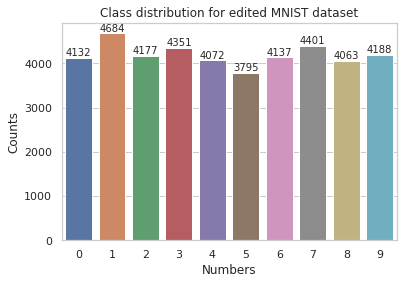

In [5]:
unique, counts = np.unique(labels, return_counts=True)
ax = sns.barplot(x=unique,y=counts)
ax.bar_label(ax.containers[0])
plt.title("Class distribution for edited MNIST dataset")
plt.ylabel("Counts")
plt.xlabel("Numbers")
plt.show()

In [6]:
import cv2

digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

# print('Digits resized', np.shape(digitsResized))

ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Visually sampling the data

img_size = 14
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digitsResized))
    plt.imshow(digitsResized[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [ ]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True


cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     # DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

In [ ]:
# given some restriction on later parts of the assignment, I've opted to train ALL
# models with said restrictions; that being training on 5000 samples, and testing on
# 37000 samples. let's see how that goes

# Part 1. INK Feature Models
- Model 1. (Zero mean and SD=1) Multinomial Logit -> Ink Feature
- Model 2. (Zero mean and SD=1) MN Logit -> Ink Feature + Our own special feature

In [ ]:
# creating ink feature
ink = np.array([sum(row) for row in digits])
ink_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ink_std = [np.std(ink[labels == i]) for i in range(10)] # std for each digit
print(f"{ink}\n{ink_mean}\n{ink_std}\n")
print(f"{np.size(ink)}, {np.size(ink_mean)}, {np.size(ink_std)}")

In [ ]:
# i didn't see much difference between scaled and non-scaled ink
scaled_ink = (ink - np.mean(ink)) / np.std(ink)
print(scaled_ink)

In [ ]:
# our new feature - whitespace between numbers
# not just the opposite of ink, but the whitespace between a digit's
# rows and columns; 0 has a LOT of whitespace, 1 doesn´t have that much
def get_whitespace_feature(digits):
    ws = np.zeros(len(digits))
    
    print(ws)
    return ws

In [ ]:
ws = get_whitespace_feature(digits)
ws_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ws_std = [np.std(ink[labels == i]) for i in range(10)] # sd for each digit
print(f"{ws}\n{ws_mean}\n{ws_std}\n")
print(f"{np.size(ws)}, {np.size(ws_mean)}, {np.size(ws_std)}")

In [ ]:
# setting up pipeline to facilitate modelling
# and consolidate training and testing datasets
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = ink.reshape(-1, 1) # reshaping since it's a single feature
y = labels
# I know the instructions mention we don´t need to do this now,
# but I´d rather keep all models (reasonably) consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.30)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression())
scaled_logit.fit(X_train, y_train)  # apply scaling on training data
scaled_logit.score(X_test, y_test)
y_pred = scaled_logit.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_results(model_desc, y_test, y_pred):
    print(f"\nResults for {model_desc}\n")
    print(classification_report(y_test, y_pred, zero_division=0)) # hiding zero division warn
    cm = confusion_matrix(y_test, y_pred, labels=scaled_logit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scaled_logit.classes_)
    disp.plot()
    plt.show()

In [ ]:
show_results("MN LOGIT - INK FEATURE", y_test, y_pred)

# Part 2. All Pixel Values Models
_**NOTE: Both with 784(14*14 pixels) features (all pixel values)**_

- Model 3. (Regularized?) MN Logit (w/ LASSO penalty) 
- Model 4. Support Vector Machines (SVM)

### MN Logit (w/ LASSO penalty)

In [ ]:
# find a way to remove all pixels that always have constant value

logreg = sklearn.linear_model.LogisticRegression(penalty='l1', c=1,solver='saga')
# saga is the only solver that supports l1 penalty and multi-class problems
#arr = np.array([ink_mean, ink_std])
#print(pd.DataFrame(arr))
#print(df.loc[:, (df.sum() > 0).all()])

### SVM + Grid Search -> All Pixel Values

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm


# === Note on kernels and params ===

# rbf: gamma
# linear: x, x'
# sigmoid: coef0
# poly: degree, coef0
#   but coef0 can be safely left unchanged "in most cases" according to 
# https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range

paramGrid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
    'degree': [0.5, 1, 2, 5],
    'gamma': ['auto', 'scale'],
}

grid = GridSearchCV(SVC(), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)